# 线性回归
:label:`sec_linear_regression`

*回归*问题在我们想要预测一个数值时出现。常见的例子包括预测价格（如房屋、股票等）、预测住院时间、预测需求（如零售销售）等。并不是每个预测问题都是经典的回归问题。稍后，我们将介绍分类问题，其中目标是预测一组类别中的成员资格。

作为一个贯穿始终的例子，假设我们希望根据房屋的面积（以平方英尺为单位）和房龄（以年为单位）来估计房价（以美元为单位）。为了开发一个预测房价的模型，我们需要获取数据，包括每栋房屋的销售价格、面积和年龄。在机器学习的术语中，这个数据集被称为*训练数据集*或*训练集*，每一行（包含一次销售对应的数据）被称为一个*样本*（或*数据点*、*实例*、*样本*）。我们试图预测的东西（价格）被称为*标签*（或*目标*）。基于这些预测的变量（房龄和面积）被称为*特征*（或*协变量*）。

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

## 基础

*线性回归*是最简单也是处理回归问题时最受欢迎的标准工具之一。追溯到19世纪初 :cite:`Legendre.1805,Gauss.1809`，线性回归基于几个简单的假设。首先，我们假设特征$\mathbf{x}$与目标$y$之间的关系大致是线性的，即条件均值$E[Y \mid X=\mathbf{x}]$可以表示为特征$\mathbf{x}$的加权和。这种设置允许目标值由于观察噪声而偏离其期望值。接下来，我们可以假设任何此类噪声都是表现良好的，遵循高斯分布。通常，我们将使用$n$来表示数据集中的样本数量。我们使用上标来枚举样本和目标，使用下标来索引坐标。更具体地说，$\mathbf{x}^{(i)}$表示第$i^{\textrm{th}}$个样本，$x_j^{(i)}$表示其第$j^{\textrm{th}}$个坐标。

### 模型
:label:`subsec_linear_model`

每个解决方案的核心是一个模型，该模型描述了如何将特征转换成对目标的估计。线性假设意味着目标（价格）的预期值可以通过特征（面积和年龄）的加权和来表达：

$$\textrm{price} = w_{\textrm{area}} \cdot \textrm{area} + w_{\textrm{age}} \cdot \textrm{age} + b.$$
:eqlabel:`eq_price-area`

这里$w_{\textrm{area}}$和$w_{\textrm{age}}$被称为*权重*，而$b$被称为*偏置*（或*偏移*或*截距*）。权重决定了每个特征对我们预测的影响程度。偏置决定了所有特征均为零时估计值是多少。尽管我们永远不会看到确切面积为零的新建房屋，但我们仍然需要偏置，因为它允许我们表达所有特征的线性函数（而不是限制我们只能通过原点的直线）。严格来说，:eqref:`eq_price-area`是对输入特征的*仿射变换*，它由通过加权和实现的*线性变换*加上通过添加偏置实现的*平移*组成。给定一个数据集，我们的目标是选择权重$\mathbf{w}$和偏置$b$，使得模型的预测平均而言尽可能地接近数据中观察到的真实价格。


在专注于仅包含少数特征的数据集的学科中，像:eqref:`eq_price-area`那样明确地长形式表达模型是很常见的。在机器学习中，我们通常处理的是高维数据集，在这种情况下使用紧凑的线性代数符号更为方便。当我们的输入包含$d$个特征时，我们可以为每个特征分配一个索引（从$1$到$d$），并将我们的预测$\hat{y}$（一般“帽子”符号表示估计）表示为

$$\hat{y} = w_1  x_1 + \cdots + w_d  x_d + b.$$

将所有特征收集到向量$\mathbf{x} \in \mathbb{R}^d$中，将所有权重收集到向量$\mathbf{w} \in \mathbb{R}^d$中，我们可以通过$\mathbf{w}$和$\mathbf{x}$之间的点积简洁地表达我们的模型：

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$
:eqlabel:`eq_linreg-y`

在:eqref:`eq_linreg-y`中，向量$\mathbf{x}$对应于单个示例的特征。我们经常发现，通过*设计矩阵*$\mathbf{X} \in \mathbb{R}^{n \times d}$引用整个数据集中$n$个示例的特征会很方便。这里，$\mathbf{X}$每行对应一个示例，每列对应一个特征。对于一组特征$\mathbf{X}$，预测$\hat{\mathbf{y}} \in \mathbb{R}^n$可以通过矩阵-向量乘积来表示：

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$
:eqlabel:`eq_linreg-y-vec`

其中，在求和过程中应用了广播(:numref:`subsec_broadcasting`)。给定训练数据集的特征$\mathbf{X}$以及相应的（已知的）标签$\mathbf{y}$，线性回归的目标是找到权重向量$\mathbf{w}$和偏置项$b$，这样，给定从与$\mathbf{X}$相同分布采样的新数据示例的特征，该新示例的标签将（按预期）以最小误差被预测。

即使我们认为给定$\mathbf{x}$预测$y$的最佳模型是线性的，我们也并不期望在一个$n$个示例的真实世界数据集中找到$y^{(i)}$恰好等于$\mathbf{w}^\top \mathbf{x}^{(i)}+b$的所有$1 \leq i \leq n$的情况。例如，无论我们使用什么仪器来观察特征$\mathbf{X}$和标签$\mathbf{y}$，都可能存在少量测量误差。因此，即使我们确信潜在关系是线性的，也会引入噪声项来解释这类误差。

在能够着手寻找最佳*参数*（或*模型参数*）$\mathbf{w}$和$b$之前，我们还需要两样东西：(i) 对给定模型质量的度量；(ii) 更新模型以提高其质量的过程。

### 损失函数
:label:`subsec_linear-regression-loss-function`

自然地，使我们的模型拟合数据需要我们就某种*适应度*（或等效地，*不适度*）达成一致。*损失函数*量化了目标的实际值与预测值之间的距离。损失通常是非负数，数值越小越好，完美预测的损失为0。对于回归问题，最常见的损失函数是平方误差。当我们对示例$i$的预测是$\hat{y}^{(i)}$，相应的真实标签是$y^{(i)}$时，*平方误差*由以下公式给出：

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
:eqlabel:`eq_mse`

常数$\frac{1}{2}$实际上没有多大区别，但在记号上比较方便，因为取损失导数时它会被抵消。由于训练数据集是给定的，并且因此不受我们控制，经验误差仅仅是模型参数的函数。在:numref:`fig_fit_linreg`中，我们可视化了一维输入问题中线性回归模型的拟合情况。

![Fitting a linear regression model to one-dimensional data.](../img/fit-linreg.svg)
:label:`fig_fit_linreg`

请注意，由于其二次形式，估计$\hat{y}^{(i)}$与目标$y^{(i)}$之间的较大差异会导致对损失更大的贡献（这种二次性质可能是一把双刃剑；虽然它鼓励模型避免大错误，但它也可能导致对异常数据过于敏感）。为了衡量模型在整个$n$个示例数据集上的质量，我们只需简单地平均（或等效地，求和）训练集上的损失：

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

在训练模型时，我们寻求参数（$\mathbf{w}^*, b^*$），它们最小化所有训练示例的总损失：

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

### 解析解

与我们将要涵盖的大多数模型不同，线性回归为我们提供了一个出乎意料容易的优化问题。特别是，我们可以通过应用一个简单的公式来解析地找到最优参数（根据训练数据评估）。首先，我们可以通过向设计矩阵附加一列全1来将偏置$b$纳入参数$\mathbf{w}$中。然后我们的预测问题是极小化$\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$。只要设计矩阵$\mathbf{X}$满秩（没有任何特征线性依赖于其他特征），那么在整个域上就会只有一个临界点，并且它对应于损失的最小值。对$\mathbf{w}$关于损失求导并将其设为零得到：

$$\begin{aligned}
    \partial_{\mathbf{w}} \|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2 =
    2 \mathbf{X}^\top (\mathbf{X} \mathbf{w} - \mathbf{y}) = 0
    \textrm{ 因此 }
    \mathbf{X}^\top \mathbf{y} = \mathbf{X}^\top \mathbf{X} \mathbf{w}.
\end{aligned}$$

解出$\mathbf{w}$提供了优化问题的最优解。
注意这个解 

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}$$

只有当矩阵$\mathbf X^\top \mathbf X$可逆时才是唯一的，
也就是说，当设计矩阵的列
线性独立时 :cite:`Golub.Van-Loan.1996`。

虽然像线性回归这样的简单问题可能有解析解，
但你不应该习惯于这样的好运。
尽管解析解允许进行很好的数学分析，
但要求解析解这一条件非常严格，
以至于它几乎排除了深度学习的所有令人兴奋的方面。

### 小批量随机梯度下降

幸运的是，即使在我们无法解析解决模型的情况下，
实践中我们仍然常常能够有效地训练模型。
此外，对于许多任务来说，
那些难以优化的模型结果往往更好，
以至于弄清楚如何训练它们最终变得非常值得。

几乎所有深度学习模型的关键优化技术，
也是我们在本书中将频繁调用的技术，
包括迭代地减少误差，
通过更新参数沿着逐步降低损失函数的方向前进。
这种算法称为*梯度下降*。

最朴素的梯度下降应用包括计算损失函数的导数，
这是通过对数据集中每个样本计算的损失取平均得到的。
实践中这可能极其缓慢：
我们必须遍历整个数据集才能做出一次更新，
即使更新步骤可能非常有效 :cite:`Liu.Nocedal.1989`。
更糟糕的是，如果训练数据中存在大量冗余，
完整更新的好处就有限了。

另一个极端是每次只考虑一个样本，
并且基于单个观测值进行更新。
由此产生的算法，*随机梯度下降*（SGD）
即使对于大型数据集也可以是一种有效的策略 :cite:`Bottou.2010`。
不幸的是，SGD既有计算上的也有统计上的缺点。
一个问题源于处理器在乘法和加法运算上比
从主内存移动数据到处理器缓存快得多的事实。
执行矩阵-向量乘法比执行相应数量的向量-向量操作效率高出一个数量级。
这意味着每次处理一个样本相比于整批处理要慢得多。
第二个问题是有些层，
如批量归一化（将在:numref:`sec_batch_norm`中描述），
只有当我们同时访问不止一个观测值时才工作良好。

解决这两个问题的方法是选择一种中间策略：
既不采用整批也不只采用单一样本，
而是采用*小批量*观测 :cite:`Li.Zhang.Chen.ea.2014`。
特定选择的小批量大小取决于许多因素，
比如内存容量、加速器数量、层的选择以及总数据集大小。
尽管如此，32到256之间的一个数字，
最好是大幂次2的倍数，是个不错的起点。
这就引出了*小批量随机梯度下降*。

在其最基本的形式中，在每次迭代$t$中，
我们首先随机抽样一个小批量$\mathcal{B}_t$，
它包含固定数量$|\mathcal{B}|$的训练样本。
然后我们计算小批量上平均损失相对于模型参数的导数（梯度）。
最后，我们将梯度乘以预定义的小正数$\eta$，
称为*学习率*，
然后从当前参数值中减去所得项。
我们可以将更新表达如下：

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

总之，小批量SGD过程如下：
(i) 初始化模型参数的值，通常随机初始化；
(ii) 迭代地从数据中随机抽样小批量，
沿负梯度方向更新参数。
对于二次损失和仿射变换，
这有一个封闭形式的展开：

$$\begin{aligned} \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) &&  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$
:eqlabel:`eq_linreg_batch_update`

因为我们选取了一个小批量$\mathcal{B}$
我们需要按其大小$|\mathcal{B}|$进行归一化。
小批量大小和学习率通常是用户定义的。
这些不在训练循环中更新的可调参数称为*超参数*。
它们可以通过诸如贝叶斯优化等技术自动调整
:cite:`Frazier.2018`。最终，解决方案的质量通常是在单独的*验证数据集*（或*验证集*）上评估的。

经过预定数量的迭代（或直到满足其他停止标准）后，
我们记录估计的模型参数，
记作$\hat{\mathbf{w}}, \hat{b}$。
需要注意的是，即使我们的函数确实是线性和无噪声的，
这些参数也不会是损失的确切最小化者，甚至不是确定性的。
虽然算法会慢慢收敛到最小化者附近，
但在有限步数内通常不会精确找到它们。
此外，用于更新参数的小批量$\mathcal{B}$
是随机选择的。
这打破了确定性。

线性回归恰好是一个具有全局最小值的学习问题
（每当$\mathbf{X}$满秩时，或者等价地，
每当$\mathbf{X}^\top \mathbf{X}$可逆时）。
然而，深度网络的损失曲面包含许多鞍点和局部最小值。
幸运的是，我们通常不关心找到
一组确切的参数，而只是找到任何一组
能够产生准确预测（从而低损失）的参数。
实践中，深度学习实践者很少挣扎于找到
能*在训练集上*最小化损失的参数
:cite:`Izmailov.Podoprikhin.Garipov.ea.2018,Frankle.Carbin.2018`。
更加艰巨的任务是找到
能够对先前未见过的数据做出准确预测的参数，
这一挑战称为*泛化*。
我们在书中多次回到这些话题。

### 预测

给定模型$\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$，
我们现在可以对新样本进行*预测*，
例如，根据其面积$x_1$和房龄$x_2$预测一栋以前未见过的房子的销售价格。
深度学习从业者已经将预测阶段称为*推理*，
但这有点用词不当——*推理*广泛指
基于证据得出的任何结论，
包括参数的值
以及对未见实例的可能标签。
如果说有什么的话，在统计文献中
*推理*更多指的是参数推理
这种术语的混用在深度学习从业者与统计学家交谈时造成了不必要的混淆。
在以下内容中，我们将尽可能坚持使用*预测*。



## 速度的向量化

当我们训练模型时，我们通常希望同时处理
整个小批量的样本。
高效地做到这一点需要（**我们**）（~~应该~~）
（**向量化计算并利用快速线性代数库，**
**而不是用Python编写昂贵的for循环。**）

为了理解为什么这很重要，
让我们（**考虑两种向量相加的方法。**）
首先，我们实例化两个包含全部为1的一万维向量。
第一种方法，我们用Python for循环遍历向量。
第二种方法，我们依赖于对`+`的单一调用。

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

现在我们可以对工作负载进行基准测试。
首先，[**我们使用for循环，一次添加一个坐标。**]

In [3]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.17176 sec'

（或者，我们依赖重载的`+`运算符来计算逐元素的和。）

In [4]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00042 sec'

第二种方法比第一种方法快得多。
向量化代码通常可以带来数量级的速度提升。
此外，我们将更多的数学运算推给了库，
这样我们就不必自己编写那么多计算，
从而减少了出错的可能性并提高了代码的可移植性。

## 正态分布与平方损失
:label:`subsec_normal_distribution_and_squared_loss`

到目前为止，我们已经对平方损失目标给出了一个相当实用的动机：
当潜在模式确实是线性的时，最优参数返回条件期望 $E[Y\mid X]$，
并且对于异常值，损失会分配较大的惩罚。
我们也可以通过对噪声分布的概率假设
为平方损失目标提供更正式的动机。

线性回归是在19世纪初发明的。
虽然高斯和勒让德谁首先想到这个想法一直存在争议，
但正是高斯发现了正态分布（也称为*高斯*）。
事实证明，正态分布
和带有平方损失的线性回归
之间的联系比共同起源更深。

首先，回想一下均值为 $\mu$ 和方差为 $\sigma^2$（标准差 $\sigma$）的正态分布
表示为

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

下面[**我们定义一个计算正态分布的函数**]。

In [5]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

我们现在可以（**可视化正态分布**）。

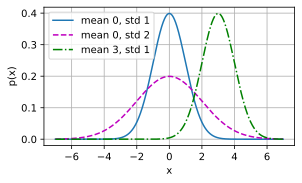

In [6]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

请注意，改变均值对应于沿$x$轴的移动，增加方差会使分布扩散，降低其峰值。

激励线性回归使用平方损失的一种方法是假设观测值来自带有噪声的测量，其中噪声$\epsilon$遵循正态分布$\mathcal{N}(0, \sigma^2)$：

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

因此，我们现在可以写出给定$\mathbf{x}$时看到特定$y$的*似然*：

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

这样，似然可以分解。根据*最大似然原则*，参数$\mathbf{w}$和$b$的最佳值是那些使整个数据集的*似然*最大化的值：

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$$

由于所有对$(\mathbf{x}^{(i)}, y^{(i)})$都是独立抽取的，所以等式成立。根据最大似然原则选择的估计量称为*最大似然估计量*。虽然最大化许多指数函数的乘积看起来很困难，但通过最大化似然的对数，我们可以在不改变目标的情况下显著简化问题。出于历史原因，优化更多时候被表达为最小化而非最大化。因此，我们可以*最小化*负对数似然，这可以表示如下：

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

如果我们假设$\sigma$是固定的，我们可以忽略第一项，因为它不依赖于$\mathbf{w}$或$b$。第二项除了乘法常数$\frac{1}{\sigma^2}$外，与前面介绍的平方误差损失相同。幸运的是，解也不依赖于$\sigma$。由此可见，最小化均方误差等价于在假设存在加性高斯噪声下线性模型的最大似然估计。

## 线性回归作为神经网络

尽管线性模型不足以表达本书中将要介绍的许多复杂网络，但（人工）神经网络足够丰富，能够将线性模型视为每个特征都由一个输入神经元表示，并且所有这些神经元都直接连接到输出的网络。

:numref:`fig_single_neuron`描绘了线性回归作为神经网络的情况。该图突出了连接模式，例如每个输入如何连接到输出，但没有具体说明权重或偏差的具体值。

![Linear regression is a single-layer neural network.](../img/singleneuron.svg)
:label:`fig_single_neuron`

输入为$x_1, \ldots, x_d$。我们将$d$称为*输入数量*或*输入层的特征维度*。网络的输出是$o_1$。因为我们只是试图预测一个数值，所以我们只有一个输出神经元。请注意，输入值都是*给定*的。只有一个*计算*出的神经元。总之，我们可以将线性回归视为单层全连接神经网络。在后面的章节中，我们将遇到具有更多层的网络。

### 生物学

因为线性回归先于计算神经科学出现，用神经网络术语来描述线性回归可能显得有些过时。然而，当控制论学家和神经生理学家Warren McCulloch和Walter Pitts开始开发人工神经元模型时，它们是一个自然的起点。考虑:numref:`fig_Neuron`中的生物神经元卡通图片，包括*树突*（输入端）、*细胞核*（CPU）、*轴突*（输出导线）和*轴突末端*（输出端），通过*突触*实现与其他神经元的连接。

![The real neuron (source: "Anatomy and Physiology" by the US National Cancer Institute's Surveillance, Epidemiology and End Results (SEER) Program).](../img/neuron.svg)
:label:`fig_Neuron`

来自其他神经元（或环境传感器）的信息$x_i$在树突处接收。特别是，这些信息由*突触权重*$w_i$加权，决定了输入的效果，例如通过乘积$x_i w_i$激活或抑制。来自多个来源的加权输入在细胞核中以加权和$y = \sum_i x_i w_i + b$的形式汇总，可能还要经过某个非线性后处理函数$\sigma(y)$。然后，该信息通过轴突发送到轴突末端，在那里到达目的地（例如，像肌肉这样的执行器），或者通过其树突馈入另一个神经元。

当然，许多这样的单元如果具有正确的连接性和学习算法，就可以结合产生比任何单个神经元所能表达的更有趣和复杂的行为，这一高层次的想法来自于我们对真实生物神经系统的研究。同时，当今深度学习的大部分研究灵感来源于更广泛的领域。我们引用了:citet:`Russell.Norvig.2016`的观点，他们指出尽管飞机可能是受鸟类启发的，但几个世纪以来，鸟类学并不是航空创新的主要驱动力。同样地，如今深度学习的灵感至少在同等程度上，甚至更大程度上来自于数学、语言学、心理学、统计学、计算机科学和其他许多领域。

## 总结

在本节中，我们介绍了传统的线性回归，其中线性函数的参数被选为在训练集上最小化平方损失。我们也通过一些实际考虑和线性回归作为在线性和高斯噪声假设下的最大似然估计的解释来动机这种目标的选择。在讨论了计算考虑和与统计学的联系之后，我们展示了如何将这样的线性模型表示为简单的神经网络，其中输入直接连接到输出。虽然我们很快就会完全超越线性模型，但它们足以引入我们的所有模型所需的大多数组件：参数形式、可微目标、通过小批量随机梯度下降进行优化，最终是在以前未见过的数据上进行评估。

## 练习

1. 假设我们有一些数据$x_1, \ldots, x_n \in \mathbb{R}$。我们的目标是找到一个常数$b$，使得$\sum_i (x_i - b)^2$最小化。
    1. 找到最优值$b$的解析解。
    1. 这个问题及其解决方案与正态分布有什么关系？
    1. 如果我们将损失从$\sum_i (x_i - b)^2$改为$\sum_i |x_i-b|$，你能找到$b$的最优解吗？
1. 证明可以用$\mathbf{x}^\top \mathbf{w} + b$表达的仿射函数等同于$(\mathbf{x}, 1)$上的线性函数。
1. 假设你想找到关于$\mathbf{x}$的二次函数，即$f(\mathbf{x}) = b + \sum_i w_i x_i + \sum_{j \leq i} w_{ij} x_{i} x_{j}$。你将如何在一个深层网络中表述这个问题？
1. 回想一下，线性回归问题可解的一个条件是设计矩阵$\mathbf{X}^\top \mathbf{X}$满秩。
    1. 如果情况不是这样会发生什么？
    1. 你怎么修复它？如果你向$\mathbf{X}$的所有条目添加少量坐标独立的高斯噪声会怎样？
    1. 在这种情况下，设计矩阵$\mathbf{X}^\top \mathbf{X}$的期望值是什么？
    1. 当$\mathbf{X}^\top \mathbf{X}$不满秩时，随机梯度下降会发生什么？
1. 假设支配加性噪声$\epsilon$的噪声模型是指数分布。即$p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$。
    1. 写出数据在模型下的负对数似然$-\log P(\mathbf y \mid \mathbf X)$。
    1. 你能找到闭式解吗？
    1. 提议一种解决此问题的小批量随机梯度下降算法。可能会发生什么问题（提示：当我们不断更新参数时，靠近平稳点会发生什么）？你能修复这个问题吗？
1. 假设我们想要通过组合两个线性层来设计一个两层的神经网络。也就是说，第一层的输出成为第二层的输入。为什么这样一个朴素的组合不起作用？
1. 如果你想用回归来进行房屋或股票价格的实际估算会发生什么？
    1. 说明加性高斯噪声假设是不适当的。提示：我们可以有负价格吗？波动呢？
    1. 为什么回归到价格的对数会更好得多，即$y = \log \textrm{price}$？
    1. 处理便士股票，即价格非常低的股票时需要担心什么？提示：你能在所有可能的价格交易吗？为什么这对便宜的股票来说是个更大的问题？更多信息请查阅著名的Black--Scholes期权定价模型 :cite:`Black.Scholes.1973`。
1. 假设我们想用回归来估计杂货店卖出的苹果数量。
    1. 高斯加性噪声模型有哪些问题？提示：你在卖苹果，而不是石油。
    1. 泊松分布捕捉计数分布。它由$p(k \mid \lambda) = \lambda^k e^{-\lambda}/k!$给出。这里$\lambda$是速率函数，$k$是你看到的事件数量。证明$\lambda$是计数$k$的期望值。
    1. 设计一个与泊松分布相关的损失函数。
    1. 设计一个用于估计$\log \lambda$的损失函数。

[讨论](https://discuss.d2l.ai/t/258)